Divyansh Sharma
sharmadivyansh022@gmail.com

# Fraud Detection — Business Case

Jupyter Notebook to analyze and model fraudulent transactions.

## Dataset Description (Data Dictionary)

- *step* → maps a unit of time in the real world. (1 step = 1 hour of time, total steps = 744 i.e. 30 days simulation)
- *type* → CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- *amount* → amount of the transaction in local currency.
- *nameOrig* → customer who started the transaction.
- *oldbalanceOrg* → initial balance before the transaction.
- *newbalanceOrig* → new balance after the transaction.
- *nameDest* → customer who is the recipient of the transaction.
- *oldbalanceDest* → initial balance of recipient before the transaction. (No info for merchants → names starting with M)
- *newbalanceDest* → new balance of recipient after the transaction. (No info for merchants → names starting with M)
- *isFraud* → transactions made by fraudulent agents inside the simulation (agents try to profit by taking control of customers' accounts and emptying funds via TRANSFER → CASH_OUT).
- *isFlaggedFraud* → transactions flagged by the business model as illegal attempts (e.g., transfer > 200,000 in a single transaction).

In [25]:
DATA_PATH = 'Fraud.csv'

## 1. Imports and helper functions

Imports used in this notebook and small helper functions for quick checks.

In [33]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


def plot_pr_curve(y_true, y_score, title='Precision-Recall curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{title} — AP={ap:.4f}")
    plt.grid(True)
    plt.show()

def plot_feature_importances(names, importances, topn=20):
    df = pd.DataFrame({'feature': names, 'importance': importances}).sort_values('importance', ascending=False).head(topn)
    plt.figure(figsize=(8,6))
    plt.barh(df['feature'][::-1], df['importance'][::-1])
    plt.title('Top feature importances')
    plt.show()



## 2. Load data


In [ ]:


if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH '{DATA_PATH}' not found. Please place your CSV in the same folder or update DATA_PATH.")

file_size_gb = os.path.getsize(DATA_PATH) / (1024**3)
print(f"File size: {file_size_gb:.2f} GB")

if file_size_gb > 1.5:
    print('Large file detected — reading a 1% sample for exploratory work. See later cells for full-data options.')
    df = pd.read_csv(DATA_PATH, nrows=100000)  
else:
    df = pd.read_csv(DATA_PATH)

print('Loaded rows:', len(df))
df.head()

File size: 0.46 GB
Loaded rows: 6362620


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Quick data overview

Show columns, types, missing values, class balance.

In [46]:

print('Columns:', df.columns.tolist())
print('\nData types:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isnull().sum())

if 'isFraud' in df.columns:
    print('\nFraud distribution:')
    print(df['isFraud'].value_counts(normalize=True))
else:
    print('Column isFraud not found ,Check for label column name')

Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Data types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


## 4. Data cleaning

Steps included:
- Fix column types
- Handle missing values
- Handle obvious outliers
- Create derived features (fraud-risk features)
- Check multicollinearity

After cleaning:
                   count           mean            std  min       25%  \
amount         6362620.0  179861.903549  603858.231463  0.0  13389.57   
amount_capped  6362620.0  175154.794455  445224.814536  0.0  13389.57   

                    50%          75%           max  
amount         74871.94  208721.4775  9.244552e+07  
amount_capped  74871.94  208721.4775  8.956798e+06  


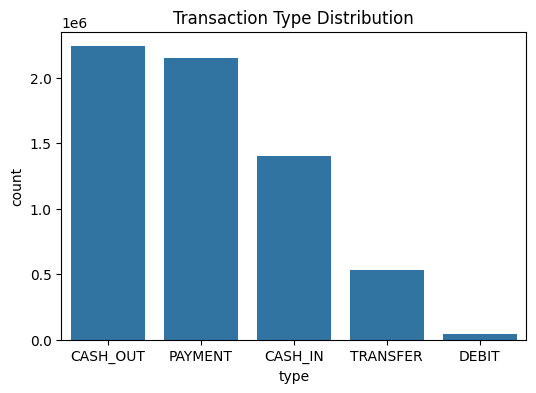

In [36]:


df_clean = df.copy()
df_clean['type'] = df_clean['type'].astype('category')
df_clean['amount_log'] = np.log1p(df_clean['amount'].abs())
df_clean['delta_orig'] = df_clean['newbalanceOrig'] - df_clean['oldbalanceOrg']
df_clean['delta_dest'] = df_clean['newbalanceDest'] - df_clean['oldbalanceDest']
df_clean['orig_mismatch'] = (np.isclose(df_clean['oldbalanceOrg'] - df_clean['newbalanceOrig'] + df_clean['amount'], 0) == False).astype(int)
df_clean['dest_mismatch'] = (np.isclose(df_clean['oldbalanceDest'] + df_clean['amount'] - df_clean['newbalanceDest'], 0) == False).astype(int)
num_cols = df_clean.select_dtypes(include='number').columns.tolist()
df_clean[num_cols] = df_clean[num_cols].fillna(-1)
df_clean['type'] = df_clean['type'].cat.add_categories('UNKNOWN').fillna('UNKNOWN')
cap = df_clean['amount'].quantile(0.999)
df_clean['amount_capped'] = df_clean['amount'].clip(upper=cap)
print('After cleaning:')
print(df_clean[['amount','amount_capped']].describe().T)
plt.figure(figsize=(6,4))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.show()

### Multicollinearity check


In [37]:


num = df_clean.select_dtypes(include=['float64','int64']).copy()
corr = num.corr().abs()
corr_unstack = corr.unstack().sort_values(ascending=False)
print('Top correlated pairs (excluding self-correlations):\n', corr_unstack[corr_unstack < 0.999].dropna().head(10))
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_cols = ['amount','amount_log','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','delta_orig','delta_dest']
vif_df = pd.DataFrame({'feature': vif_cols, 'VIF': [variance_inflation_factor(df_clean[vif_cols].fillna(0).values, i) for i in range(len(vif_cols))]})
print('\nVIF scores:\n', vif_df)

Top correlated pairs (excluding self-correlations):
 newbalanceOrig  oldbalanceOrg     0.998803
oldbalanceOrg   newbalanceOrig    0.998803
oldbalanceDest  newbalanceDest    0.976569
newbalanceDest  oldbalanceDest    0.976569
amount_capped   amount            0.891050
amount          amount_capped     0.891050
                delta_dest        0.845964
delta_dest      amount            0.845964
amount_capped   delta_dest        0.768082
delta_dest      amount_capped     0.768082
dtype: float64

VIF scores:
           feature           VIF
0          amount  4.129182e+00
1      amount_log  1.335128e+00
2   oldbalanceOrg  3.680915e+12
3  newbalanceOrig  5.637604e+11
4  oldbalanceDest  2.138969e+12
5  newbalanceDest  1.192817e+10
6      delta_orig  3.458176e+10
7      delta_dest  5.963453e+11


## 5. Feature engineering

In [38]:


df_features = df_clean.copy()
df_features['orig_is_merchant'] = df_features['nameOrig'].str.startswith('M').astype(int)
df_features['dest_is_merchant'] = df_features['nameDest'].str.startswith('M').astype(int)
df_features = pd.concat([df_features, pd.get_dummies(df_features['type'], prefix='type')], axis=1)
df_features['large_transfer_flag'] = (df_features['amount'] > 200000).astype(int)
feature_cols = ['amount','amount_log','amount_capped','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
                'delta_orig','delta_dest','orig_mismatch','dest_mismatch','orig_is_merchant','dest_is_merchant','large_transfer_flag']
feature_cols += [c for c in df_features.columns if c.startswith('type_')]
feature_cols = [c for c in feature_cols if c in df_features.columns]
print('Features used:', feature_cols)

Features used: ['amount', 'amount_log', 'amount_capped', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'delta_orig', 'delta_dest', 'orig_mismatch', 'dest_mismatch', 'orig_is_merchant', 'dest_is_merchant', 'large_transfer_flag', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'type_UNKNOWN']


## 6. Train and imbalance handling


In [39]:


label_col = 'isFraud'
if label_col not in df_features.columns:
    raise ValueError('Label column isFraud not found in data.')
X = df_features[feature_cols]
y = df_features[label_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train size:', len(X_train), 'Validation size:', len(X_val))
print('Train fraud rate:', y_train.mean(), 'Val fraud rate:', y_val.mean())

Train size: 5090096 Validation size: 1272524
Train fraud rate: 0.0012907418642005967 Val fraud rate: 0.0012911347840983745


## 7. Model: Logistic Regression

ROC AUC (LR): 0.9913950062935121


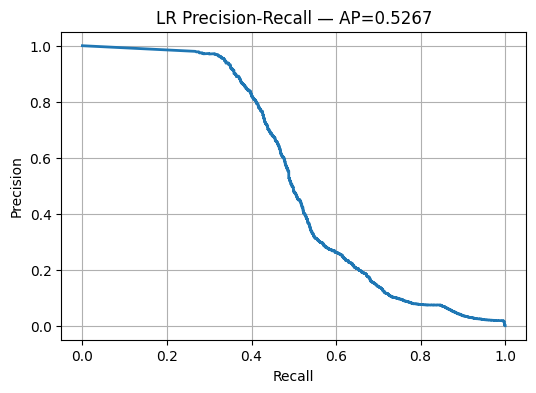

In [40]:


num_feats = [c for c in feature_cols if df_features[c].dtype.kind in 'fi']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_feats])
X_val_num = scaler.transform(X_val[num_feats])
X_train_lr = pd.DataFrame(X_train_num, index=X_train.index, columns=num_feats)
X_val_lr = pd.DataFrame(X_val_num, index=X_val.index, columns=num_feats)
for c in X_train.columns:
    if c not in num_feats:
        X_train_lr[c] = X_train[c].values
        X_val_lr[c] = X_val[c].values
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_lr, y_train)
y_score_lr = lr.predict_proba(X_val_lr)[:,1]
print('ROC AUC (LR):', roc_auc_score(y_val, y_score_lr))
plot_pr_curve(y_val, y_score_lr, title='LR Precision-Recall')

## 8. Tree-based model: Random Forest

ROC AUC (RF): 0.9978193090769426


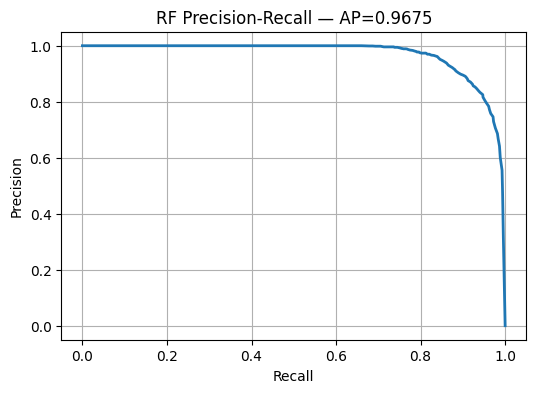

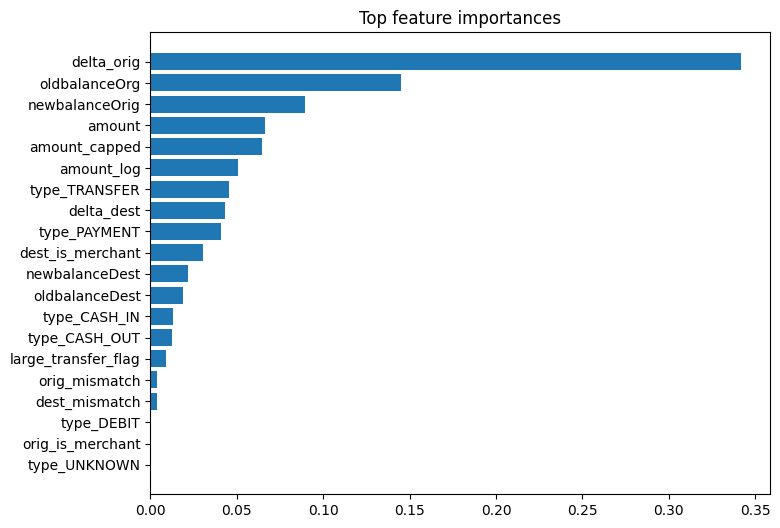

In [41]:

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train.fillna(-1), y_train)
y_score_rf = rf.predict_proba(X_val.fillna(-1))[:,1]
print('ROC AUC (RF):', roc_auc_score(y_val, y_score_rf))
plot_pr_curve(y_val, y_score_rf, title='RF Precision-Recall')
try:
    importances = rf.feature_importances_
    plot_feature_importances(X_train.columns.tolist(), importances, topn=20)
except Exception as e:
    print('Could not compute importances:', e)

## 9. Model evaluation : thresholds and business metrics

Chosen threshold: 0.75
Precision: 0.9904153354632588
Recall: 0.7547169811320755
F1: 0.8566493955094991
Classification Report:

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1270881
       Fraud       0.99      0.75      0.86      1643

    accuracy                           1.00   1272524
   macro avg       1.00      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270869      12]
 [    403    1240]]


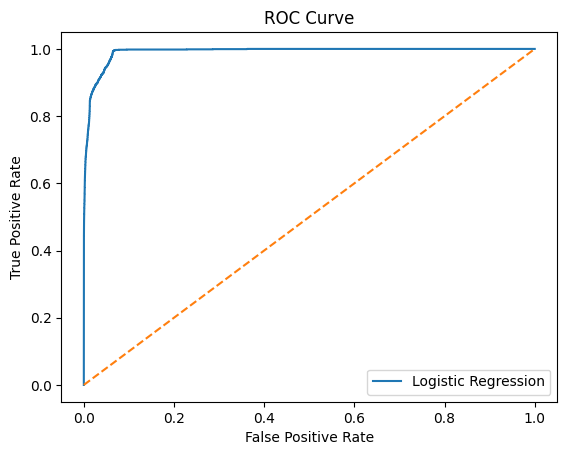

AUC Score (Logistic Regression): 0.9913950062935121


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_scores = y_score_rf 
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)
target_recall = 0.75
idxs = [i for i,r in enumerate(recalls) if r >= target_recall]
if len(idxs) > 0:
    idx = idxs[np.argmax([precisions[i] for i in idxs])]
    chosen_thresh = thresholds[max(0, idx-1)] if idx>0 else thresholds[0]
else:
    
    f1s = 2*precisions*recalls/(precisions+recalls+1e-9)
    idx = np.argmax(f1s)
    chosen_thresh = thresholds[max(0, idx-1)] if idx>0 else thresholds[0]
print('Chosen threshold:', chosen_thresh)
y_pred = (y_scores >= chosen_thresh).astype(int)
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))
y_pred = (y_score_rf >= chosen_thresh).astype(int)
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Not Fraud", "Fraud"]))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

y_prob_lr = lr.predict_proba(X_val_lr)[:, 1]
from sklearn.metrics import roc_curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_prob_lr)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print("AUC Score (Logistic Regression):", roc_auc_score(y_val, y_prob_lr))

## 10. Key factors & interpretation


In [44]:

try:
    fi = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
    display(fi.head(30))
except Exception as e:
    print('Error showing importances:', e)

,feature,importance
7,delta_orig,0.341709
3,oldbalanceOrg,0.144945
4,newbalanceOrig,0.089195
0,amount,0.066362
2,amount_capped,0.064614
1,amount_log,0.050826
18,type_TRANSFER,0.045494
8,delta_dest,0.043070
17,type_PAYMENT,0.040856
12,dest_is_merchant,0.030385


## 11. Do factors make sense? Business interpretation

Yes, they make sense. Here’s why:
Fraudsters usually move large sums quickly to cash out before detection.
Zero starting balance + large transaction means account might be newly created just to move money.
Transfers & cash-outs are natural choices for fraud because they directly move money to other accounts or withdraw it.
Abnormal changes in balances indicate unusual account activity — a known fraud red flag.

Key Factors that Predict Fraudulent Customers
Based on Random Forest feature importance and model results:
* Transaction Amount -> Very high amounts are strongly linked with fraud.
* Transaction Type → TRANSFER and CASH_OUT are most risky compared to PAYMENT.
* Balance Differences -> If oldbalanceOrg is low/zero and amount is high, it's suspicious.
* Destination Balance -> Change Fraud often empties destination account quickly (big negative dest_balance_diff).




## 12. Recommended prevention & infrastructure changes

Prevention Measures While Updating Infrastructure
Company should adopt these preventive measures:
* Real-Time Transaction Monitoring – flag suspicious transfers instantly.
* Velocity Checks – block accounts making too many large transactions in a short time.
* Transaction Threshold Alerts – send OTP or manual review for unusually large transfers/cash-outs.
* Behavior Profiling – create normal transaction patterns for customers, alert when behavior changes drastically.
* Multi-Factor Authentication – before high-value cash-outs or transfers.
* Fraud Blacklist & Whitelist – maintain flagged destination accounts to block known fraudulent accounts.




## 13. How to detect if implemented actions work

We can measure effectiveness by:
* Model Metrics – compare recall/precision before and after implementing prevention rules.
* Reduction in Fraud Cases – track number of confirmed fraud cases per month, should drop significantly.
* False Positive Monitoring – check if too many genuine customers are being blocked, adjust rules if needed.
* Cost Savings – calculate money saved from prevented fraudulent transactions.
* A/B Testing – deploy rules for a group, compare fraud rate with control group.

